In [2]:
import numpy as np
import tensorflow as tf

from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import GRU, Flatten, Dropout, Dense, BatchNormalization, Activation
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import metrics

import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.


In [3]:
# Define model architecture
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,22)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=[metrics.AUC()])

# Print model summary
print(model.summary())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 24, 30)            4770      
_________________________________________________________________
flatten_1 (Flatten)          (None, 720)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 720)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                28840     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
__________________________

In [4]:
# Load the data
_data = np.load('res/data.npy', allow_pickle=True).tolist()
X_train = _data['X_train_norm']
y_train = _data['y_train']
X_val = _data['X_val_norm']
y_val = _data['y_val']
X_test = _data['X_test_norm']
y_test = _data['y_test']
print("Loaded!")

Loaded!


In [5]:
# Print information about the created arrays
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of patients who died in hospital in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of patients who died in hospital in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 38549
No. of patients in train, val, test sets: 30839, 3855, 3855
No. of patients who died in hospital in train, val, test sets: 3458.0, 417.0, 445.0
Proportion of patients who died in hospital in train, val, test sets: 11.213%, 10.817%, 11.543%


In [6]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (30839, 22, 24)
y_train: (30839,)
X_val: (3855, 22, 24)
y_val: (3855,)
X_test: (3855, 22, 24)
y_test: (3855,)


In [7]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [8]:
# Check the shapes of the arrays again
print("X_train: {}".format(np.shape(X_train)))
print("X_val: {}".format(np.shape(X_val)))
print("X_test: {}".format(np.shape(X_test)))

X_train: (30839, 24, 22)
X_val: (3855, 24, 22)
X_test: (3855, 24, 22)


In [9]:
# Define the early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=250, batch_size=100, verbose=1, callbacks=[es])


Train on 30839 samples, validate on 3855 samples
Epoch 1/250
30839/30839 [==============================] - 4s 140us/step - loss: 0.6100 - auc_1: 0.8319 - val_loss: 0.4357 - val_auc_1: 0.8656
Epoch 2/250
30839/30839 [==============================] - 4s 121us/step - loss: 0.4884 - auc_1: 0.8645 - val_loss: 0.4176 - val_auc_1: 0.8819
Epoch 3/250
30839/30839 [==============================] - 4s 123us/step - loss: 0.4173 - auc_1: 0.8796 - val_loss: 0.3879 - val_auc_1: 0.8908
Epoch 4/250
30839/30839 [==============================] - 4s 118us/step - loss: 0.3645 - auc_1: 0.8899 - val_loss: 0.3329 - val_auc_1: 0.8954
Epoch 5/250
30839/30839 [==============================] - 4s 119us/step - loss: 0.3261 - auc_1: 0.8934 - val_loss: 0.3047 - val_auc_1: 0.8994
Epoch 6/250
30839/30839 [==============================] - 4s 119us/step - loss: 0.2956 - auc_1: 0.9018 - val_loss: 0.2926 - val_auc_1: 0.8986
Epoch 7/250
30839/30839 [==============================] - 4s 119us/step - loss: 0.2741 - au

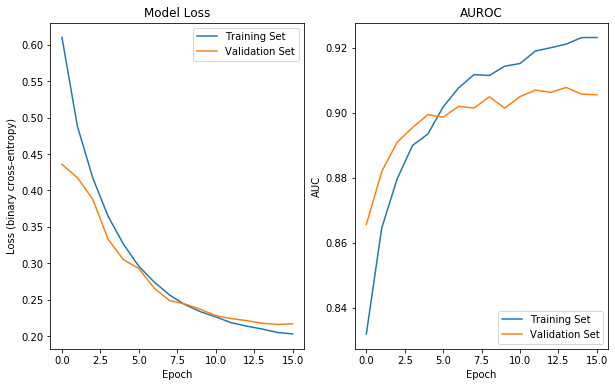

In [10]:
# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(10,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the AUC
ax2.plot(history.history['auc_1'])
ax2.plot(history.history['val_auc_1'])
ax2.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [11]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred = model.predict(X_test).ravel()
fpr_rnn, tpr_rnn, thresholds_rnn = roc_curve(y_test, y_pred)

In [12]:
# Calculate the AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_rnn = auc(fpr_rnn, tpr_rnn)

In [13]:
# Write a function that plots nice confusion matrices
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm[0][0] = round(cm[0][0],2)
        cm[0][1] = round(cm[0][1],2)
        cm[1][0] = round(cm[1][0],2)
        cm[1][1] = round(cm[1][1],2)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

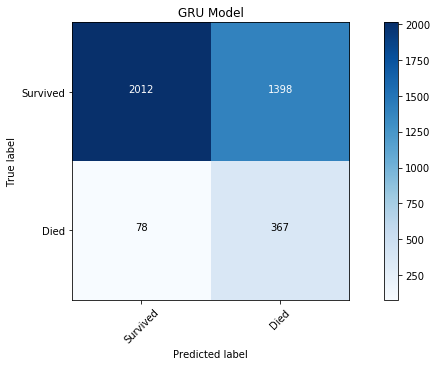

In [40]:
# Calculate the confusion matrix
decision_threshold = 0.3
cm = confusion_matrix(y_test, y_pred[:]>decision_threshold)
plot_confusion_matrix(cm, ['Survived', 'Died'], normalize=False, title='GRU Model')

In [41]:
# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred[:]>decision_threshold)

0.6171206225680934

In [15]:
# Load the raw data
_data = np.load('res/data.npy', allow_pickle=True).tolist()
X_train_raw = _data['X_train']
X_test_raw = _data['X_test']
print("Loaded!")

Loaded!


In [16]:
# Prepare training data for non-temporal models
m, n, T = np.shape(X_train_raw)
X_train_static = np.zeros((m,n*4))
for i in range(m):
    for j in range(n):
        feature = X_train_raw[i,j,:]
        extracted_features = [np.min(feature), np.max(feature), np.mean(feature), np.std(feature)]
        X_train_static[i,(j*4):(j*4+4)] = extracted_features
        
# Prepare test data for non-temporal models
m, n, T = np.shape(X_test_raw)
X_test_static = np.zeros((m,n*4))
for i in range(m):
    for j in range(n):
        feature = X_test_raw[i,j,:]
        extracted_features = [np.min(feature), np.max(feature), np.mean(feature), np.std(feature)]
        X_test_static[i,(j*4):(j*4+4)] = extracted_features
        
# Check the shapes of the new arrays
print("X_train_static: {}".format(np.shape(X_train_static)))
print("X_test_static: {}".format(np.shape(X_test_static)))

X_train_static: (30839, 88)
X_test_static: (3855, 88)


In [17]:
# Scale the training data using a z-transform, and apply that scaler to the test data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_static)
X_test_scaled = scaler.transform(X_test_static)
print(np.shape(X_train_scaled))

(30839, 88)


In [18]:
# Create logistic regression classifer object
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = "liblinear")

# Train logistic regression classifer
logisticRegr.fit(X_train_scaled, y_train)

# Predict the response for test dataset
y_pred = logisticRegr.predict_proba(X_test_scaled)[:,1]

In [19]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred)

In [20]:
# Calculate the AUROC for the test set using logistic regression
auc_lr = auc(fpr_lr, tpr_lr)

In [21]:
# Create a function to calculate the SAPS II score given some input data
def saps_ii(data):
    
    '''
    Function to calculate the SAPS II clinical score, and predicted mortality, for each patient.
    
    INPUTS:
    data - array of shape (m,n*4), where m = number of patients and n = number of features, and each feature has a min, max, mean and std.
    
    OUTPUTS:
    saps_ii - array of shape (m,1), with the calculated SAPS II clinical score.
    mortality - array of shape (m,1), with the predicted mortality from the corresponding SAPS II score.
    '''
    
    # Define variables
    m, n = np.shape(data)
    age = data[:,(3*4)+2]
    sched_surg = data[:,(0*4)+2]
    medical = data[:,(2*4)+2]
    unsched_surg = data[:,(1*4)+2]
    hr = data[:,(14*4)+2]
    bp = data[:,(9*4)+2]
    temp = data[:,(18*4)+2]
    gcs = data[:,(11*4)+2] + data[:,(12*4)+2] + data[:,(13*4)+2]
    urine = data[:,(20*4)+2]
    urea = data[:,(19*4)+2]
    sodium = data[:,(17*4)+2]
    potassium = data[:,(16*4)+2]
    bicarb = data[:,(7*4)+2]
    bilirubin = data[:,(8*4)+2]
    wbc = data[:,(21*4)+2]
    mets = data[:,(6*4)+2]
    haem = data[:,(4*4)+2]
    aids = data[:,(5*4)+2]
    
    # Calculate SAPS II
    saps_ii = np.zeros((m,1))
    
    for i in range(m):
        
        # Age
        if age[i] >= 40 and age[i] < 60:
            saps_ii[i] += 7
        elif age[i] >= 60 and age[i] < 69:
            saps_ii[i] += 12
        elif age[i] >= 70 and age[i] < 75:
            saps_ii[i] += 15
        elif age[i] >= 75 and age[i] < 80:
            saps_ii[i] += 16
        elif age[i] >= 80:
            saps_ii[i] += 18
            
        # Type of admission
        if unsched_surg[i] == 1:
            saps_ii[i] += 8
        elif medical[i] == 1:
            saps_ii[i] += 6
        
        # Heart rate
        if hr[i] < 40:
            saps_ii[i] += 11
        elif hr[i] >= 40 and hr[i] < 70:
            saps_ii[i] += 2
        elif hr[i] >= 70 and hr[i] < 120:
            saps_ii[i] += 0
        elif hr[i] >= 120 and hr[i] < 160:
            saps_ii[i] += 4
        elif hr[i] >= 160:
            saps_ii[i] += 7
        
        # Blood pressure
        if bp[i] < 70:
            saps_ii[i] += 13
        elif bp[i] >= 70 and bp[i] < 100:
            saps_ii[i] += 5
        elif bp[i] >= 100 and bp[i] < 200:
            saps_ii[i] += 0
        elif bp[i] >= 200:
            saps_ii[i] += 2
        
        # Temperature
        if temp[i] >= 39:
            saps_ii[i] += 3
            
        # Glasgow Coma Scale
        if gcs[i] < 6:
            saps_ii[i] += 26
        elif gcs[i] >= 6 and gcs[i] < 9:
            saps_ii[i] += 13
        elif gcs[i] >= 9 and gcs[i] < 11:
            saps_ii[i] += 7
        elif gcs[i] >= 11 and gcs[i] < 14:
            saps_ii[i] += 5
        elif gcs[i] < 14:
            saps_ii[i] += 0
        
        # Urine output
        if urine[i]*24 < 0.5:
            saps_ii[i] += 11
        elif urine[i]*24 >= 0.5 and urine[i]*24 < 1:
            saps_ii[i] += 4
            
        # Urea
        if urea[i] >= 0.6 and urea[i] < 1.8:
            saps_ii[i] += 0
        elif urea[i] >= 1.8:
            saps_ii[i] += 2
        
        # Sodium
        if sodium[i] < 125:
            saps_ii[i] += 5
        elif sodium[i] >= 125 and sodium[i] < 145:
            saps_ii[i] += 0
        elif sodium[i] >= 145:
            saps_ii[i] += 1
        
        # Potassium
        if potassium[i] < 3:
            saps_ii[i] += 3
        elif potassium[i] >= 3 and potassium[i] < 5:
            saps_ii[i] += 0
        elif potassium[i] >= 5:
            saps_ii[i] += 3
        
        # Bicarbonate
        if bicarb[i] < 15:
            saps_ii[i] += 6
        elif bicarb[i] >= 15 and bicarb[i] < 20:
            saps_ii[i] += 3
        elif bicarb[i] >= 20:
            saps_ii[i] += 0
        
        # Bilirubin
        if bilirubin[i] < 4:
            saps_ii[i] += 0
        elif bilirubin[i] >= 4 and bilirubin[i] < 6:
            saps_ii[i] += 4
        elif bilirubin[i] >= 6:
            saps_ii[i] += 9
        
        # White blood cells
        if wbc[i] < 1000:
            saps_ii[i] += 12
        elif wbc[i] >= 1000 and wbc[i] < 20000:
            saps_ii[i] += 0
        elif wbc[i] >= 20000:
            saps_ii[i] += 3
        
        # Chronic diseases
        if aids[i] == 1:
            saps_ii[i] += 17
        elif haem[i] == 1:
            saps_ii[i] += 10
        elif mets[i] == 1:
            saps_ii[i] += 9
        
    # Calculate mortality
    mortality = np.zeros((m,1))
    
    for i in range(m):
        
        logit = -7.7631 + 0.0737*saps_ii[i] + 0.9971*np.log(saps_ii[i]+1)
        
        mortality[i] = np.exp(logit) / (1 + np.exp(logit))
    
    # Return results
    return saps_ii, mortality

In [22]:
# Calculate SAPS II score and make predictions
saps_scores, y_pred = saps_ii(X_test_static)

In [23]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
fpr_saps, tpr_saps, thresholds_saps = roc_curve(y_test, y_pred)

In [24]:
# Calculate the AUROC for the test set
auc_saps = auc(fpr_saps, tpr_saps)

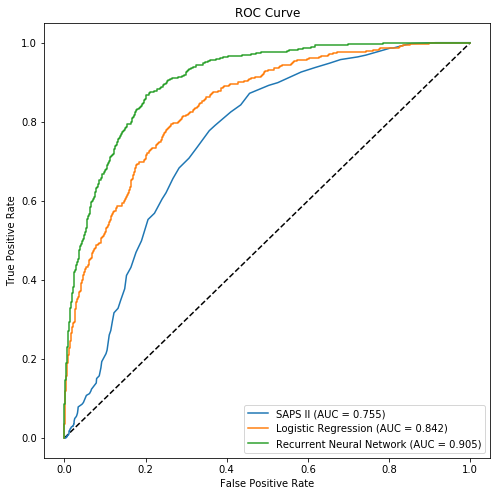

In [28]:
# Plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_saps, tpr_saps, label='SAPS II (AUC = {:.3f})'.format(auc_saps))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = {:.3f})'.format(auc_lr))
plt.plot(fpr_rnn, tpr_rnn, label='Recurrent Neural Network (AUC = {:.3f})'.format(auc_rnn))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png', bbox_inches='tight')
plt.show()